## Introduction

We will analyze and compare neighborhoods between New York City, New York and Toronto, ON, Canada in this project. Our client in North East Asia wants to set up a new North America branch, and Toronto and New York City were selected as the two cities for their final decision. The company wants some insight into the neighborhoods and local businesses in the cities so that its employees can have quality of life while they work or live in the city. This project will explore the similarities and dissimilarities between certain neighborhoods in the two cities, and suggest which neighborhoods would fit the culture of the client's employees the best.

## Data

In this project, the data will be acquired from various sources. We will be using the datasets as follows:

#### Dataset1
New York City neighborhoods - https://geo.nyu.edu/catalog/nyu_2451_34572 

#### Dataset2
Toronto neighborhoods - https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.

#### Dataset3
Toronto's geospatial information - https://cocl.us/Geospatial_data

#### Dataset4
Foursquare API data

The Dataset2 and Dataset3 will be merged based on their postal codes, which will generate a dataset consisting of the postal codes, boroughs, neighborhoods, latitude, and longitude information for Toronto. Dataset1 has the boroughs, neighborhoods, latitude and longitude information for New York City. Foursquare API search feature will be used to collect neighborhood venue information for each city.  

## Table of Contents

1. <a href="#item1">Download and Explore Dataset</a>
2. <a href="#item2">Explore Neighborhoods</a>
3. <a href="#item3">Analyze Each Neighborhood</a>
4. <a href="#item4">Cluster Neighborhoods</a>
5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
!pip install geopy
!pip install folium
!pip install bs4

     |████████████████████████████████| 112kB 28.8MB/s eta 0:00:01
     |████████████████████████████████| 112kB 9.3MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


In [2]:
import numpy as np   # library to handle data in a vectorized manner
import pandas as pd  # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json          # library to handle JSON files

from geopy.geocoders import Nominatim   # convert an address into latitude and longitude values
import requests      # library to handle requests
from pandas.io.json import json_normalize  # transfrom JSON file into a pandas dataframe

# Matplotlib and associated plotting modlues
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

import folium    # Map rendering library

from bs4 import BeautifulSoup    # Package to transfrom the data of webpage to pandas dataframme

print('Libraries imported.')

Libraries imported.


### 1. Download and Explore Dataset (NYC)

In New York City, neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and longitude coordinates of each neighborhood. 

This dataset exists on the web. Here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572
But we simply download the file from the server, so we can simply run a wget command and access the data. And then we will load the data and transform the data into a pandas dataframe. 

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [4]:
# Define the datafram columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

#Instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Let's loop through the data and fill the dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough':borough, 'Neighborhood':neighborhood_name, 
                                          'Latitude':neighborhood_lat, 'Longitude':neighborhood_lon}, ignore_index=True)
neighborhoods.head()    

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
      )
)

The dataframe has 5 boroughs and 306 neighborhoods.


For Toronto, we are going to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, 
in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe.

In [6]:
#download data and parse it
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'html.parser')

In [7]:
#obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe
table = soup.find('table')
td = table.find_all('td')
postcode = []
borough = []
neighborhood = []

for i in range(0, len(td), 3):
    postcode.append(td[i].text.strip())
    borough.append(td[i+1].text.strip())
    neighborhood.append(td[i+2].text.strip())

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
df = pd.DataFrame(data=[postcode, borough, neighborhood]).transpose()
df.columns = ['Postal Code', 'Borough', 'Neighborhood']

# Drop cells with a borough that is 'Not assigned'
df['Borough'].replace('Not assigned', np.nan, inplace=True)
df.dropna(subset=['Borough'], inplace=True)

# If a cell has a Borough but a 'Not assigned' Neighborhood, then the Neighborhood will be the same as the Borough
df['Neighborhood'].replace('Not assigned',df.Borough, inplace=True)

# If more than one neighborhood exist in one postal code area, the relevant rows will be combined into one row 
# with the neighborhoods separated with a comma
df = df.groupby(['Postal Code','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name.
Here, we will incorporate the latitude and the longitude coordinates of each neighborhood in the dataframe.

In [8]:
# csv file that has the geographical coordinates of each postal code
url2 = 'http://cocl.us/Geospatial_data'
geospatial_df = pd.read_csv(url2)
geospatial_df.columns = ['Postal Code', 'Latitude', 'Longitude']
toronto_df = pd.merge(df, geospatial_df, on=['Postal Code'], how='inner')
toronto_df.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


How many boroughs and unique postal codes in Toronto?

In [9]:
print('The dataframe has {} boroughs and {} postal codes.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 11 boroughs and 103 postal codes.


Thus, New York City has 5 boroughs and 306 unique neighborhoods, and Toronto has 11 boroughs and 103 unique postal codes.

## 2. Explore Neighborhoods

#### Use Geolibrary to get the latitude and longitude of New York City

In [10]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


And let's visualize Manhattan and the neighborhoods in it.

In [14]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to utilize the Foursqure API to explore the neighborhoods and segment them.

The map shows that the Neighborhoods are not evenly spaced, and the area cover by some of them, using a radius 500 meters, overlaps. A different radius for each neighborhood results in a better venues search because that will avoid misrepresentation of the number of venues per neighborhood caused by too large or low radius values.

To define the radius use with Foursquare, it's necessary to find the closest points for each neighborhood.

In [15]:
from geopy.distance import great_circle

#function to get the closest neighborhood pair and the distance using latitude and longitude
def closest_neighborhood(neighborhood, neighborhoods):
    neighborhood = np.asarray(neighborhood).reshape(1,-1)
    neighborhoods = np.asarray(neighborhoods)
    distances = [great_circle(neighborhood, point).meters for point in neighborhoods]
    closest_neighborhood_index = np.argmin(distances)
    return [round(distances[closest_neighborhood_index]), closest_neighborhood_index]

To explore the distance function, the closest neighborhood to the first example in the dataframe is:

In [16]:
X = manhattan_data[['Longitude','Latitude']]
coordinates = manhattan_data[['Latitude','Longitude']]
distance, closest_point_index = closest_neighborhood(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-73.91066,40.876551
3,-73.92121,40.867684


'Distance' column is added to the data frame and is used as the radius cover for each neighborhood.

In [17]:
from math import isnan

for lat, lng, idx in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data.index):
    distance, closest_point_index = closest_neighborhood([lat,lng], coordinates[~coordinates.index.isin([idx])])
    manhattan_data.at[idx,'Distance'] = np.int64(distance//2)  # use the half of the distance to avoid overlapping

manhattan_data.head(10)    

,Borough,Neighborhood,Latitude,Longitude,Distance
0,Manhattan,Marble Hill,40.876551,-73.910660,663.0
1,Manhattan,Chinatown,40.715618,-73.994279,242.0
2,Manhattan,Washington Heights,40.851903,-73.936900,1098.0
3,Manhattan,Inwood,40.867684,-73.921210,663.0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,492.0
5,Manhattan,Manhattanville,40.816934,-73.957385,492.0
6,Manhattan,Central Harlem,40.815976,-73.943211,504.0
7,Manhattan,East Harlem,40.792249,-73.944182,655.0
8,Manhattan,Upper East Side,40.775639,-73.960508,424.0
9,Manhattan,Yorkville,40.775930,-73.947118,456.0


The following will go through the same process for Toronto. Let's explore the neighborhoods in Toronto.

#### Use geopy library to get the latitude and longitude values of Toronto.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>toronto_explorer</em>, as shown below.

In [18]:
address1 = 'Toronto, ON, CA'

geolocator1 = Nominatim(user_agent="toronto_explorer")
location1 = geolocator.geocode(address1)
latitude1 = location1.latitude
longitude1 = location1.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [19]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, borough, postalcode in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Postal Code']):
    label = '{}, {}'.format(postalcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

For illustration purposes, let's simplify the above map and segment and cluster only the boroughs that contain the word Toronto. So let's slice the original dataframe and create a new dataframe.

In [20]:
toronto_df_new = toronto_df[toronto_df['Borough'].str.contains('Toronto').reset_index(drop=True)]
toronto_df_new.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [21]:
address1 = 'Old toronto, ON, CA'

geolocator1 = Nominatim(user_agent="oldtoronto_explorer")
location1 = geolocator.geocode(address1)
latitude1 = location1.latitude
longitude1 = location1.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of Toronto are 43.67368315, -79.37984349253107.


#### Create a map of Old Toronto with neighborhoods superimposed on top.

In [22]:
# create map of Toronto using latitude and longitude values
map_oldtoronto = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, borough, postalcode in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['Borough'], toronto_df_new['Postal Code']):
    label = '{}, {}'.format(postalcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oldtoronto)  
    
map_oldtoronto

The map shows that the Neighborhoods are not evenly spaced, and the area cover by some of them, using a radius 500 meters, overlaps. A different radius for each neighborhood results in a better venues search because that will avoid misrepresentation of the number of venues per neighborhood caused by too large or low radius values.

To define the radius use with foursquare, it's necessary to find the closest points for each neighborhood.

In [23]:
from geopy.distance import great_circle

#function to get the closest postal code pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

To explore the distance function, the closest neighborhood to the first example in the dataframe is:

In [24]:
X1 = toronto_df_new[['Longitude','Latitude']]
coordinates = toronto_df_new[['Latitude','Longitude']]
distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X1[:1].append(X1[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
37,-79.293031,43.676357
41,-79.352188,43.679557


'Distance' column is added to the data frame and is used as the radius cover for each postal code.

In [25]:
from math import isnan

for lat, lng, idx in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    toronto_df_new.at[idx,'Distance'] = np.int64(distance//2)  # use the half of the distance to avoid overlapping

toronto_df_new.head(10)    

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,994.0
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,896.0
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,423.0
43,M4M,East Toronto,Studio District,43.659526,-79.340923,799.0
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,851.0
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197,472.0
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,496.0
47,M4S,Central Toronto,Davisville,43.704324,-79.388790,472.0
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,601.0
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,701.0


#### Define Foursquare Credentials and Version

In [26]:
CLIENT_ID = 'ZTECIQ2ZHQ4YJJT0SJ1CVBCUSUZGZUUTW5AROJZAN312T1AE' # your Foursquare ID
CLIENT_SECRET = 'YP5Z0HLTDU1RC3HNNAJ20XN5KIWJPQFWIX5KIEKABOAZPKSW' # your Foursquare Secret
VERSION = '20200201' # Foursquare API version

## 3. Get Venues in each Neighborhood

#### Let's create a function to get the nearby venues in each neighborhood in Manhattan.

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'], latitudes=manhattan_data['Latitude'], longitudes=manhattan_data['Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Let's check the size of the resulting dataframe

In [28]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3307, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In order to get a better sense of the best way of clustering the neighborhoods, it is necessary to analyze the venues data returned by Foursquare.

In [29]:
venues_in_neighborhood = manhattan_venues.groupby('Neighborhood').count()
venues_in_neighborhood = pd.DataFrame(list(zip(venues_in_neighborhood.index,venues_in_neighborhood['Venue'])),
                                     columns=['Neighborhood','# of Venues']).set_index('Neighborhood').join(manhattan_data[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
venues_in_neighborhood['Distance'] = np.int64(venues_in_neighborhood['Distance'])
venues_in_neighborhood.head(10)

,Neighborhood,# of Venues,Distance
0,Battery Park City,97,374
1,Carnegie Hill,98,456
2,Central Harlem,44,504
3,Chelsea,100,549
4,Chinatown,100,242
5,Civic Center,100,410
6,Clinton,100,216
7,East Harlem,41,655
8,East Village,100,365
9,Financial District,100,374


In [30]:
venues_in_neighborhood[['# of Venues']].describe()

,# of Venues
count,40.000000
mean,82.675000
std,26.812155
min,18.000000
25%,61.000000
50%,100.000000
75%,100.000000
max,100.000000


The venues frequency distribution is presented next.

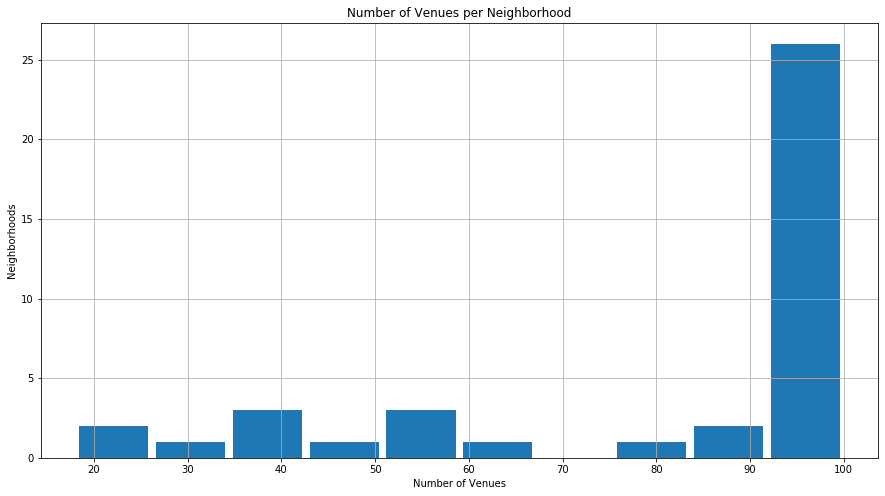

In [71]:
import matplotlib.pyplot as plt
venues_in_neighborhood['# of Venues'].hist(figsize=(15,8), rwidth=0.9)
plt.xlabel('Number of Venues')
plt.ylabel('Neighborhoods')
plt.title('Number of Venues per Neighborhood')
plt.show()

Given that each neighborhood has a different radius passed to the venues request, it's better to present the venues per Neighborhood in terms of density.

In [32]:
density_venues_in_neighborhood = manhattan_venues.groupby('Neighborhood').count()
density_venues_in_neighborhood = pd.DataFrame(list(zip(density_venues_in_neighborhood.index, density_venues_in_neighborhood['Venue'])),
                                             columns=['Neighborhood','Density']).set_index('Neighborhood').join(manhattan_data[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
density_venues_in_neighborhood['Density'] = np.int64(density_venues_in_neighborhood['Density']/(density_venues_in_neighborhood['Distance']/1000))  #distance in km

density_venues_in_neighborhood.head(10)

,Neighborhood,Density,Distance
0,Battery Park City,259,374.0
1,Carnegie Hill,214,456.0
2,Central Harlem,87,504.0
3,Chelsea,182,549.0
4,Chinatown,413,242.0
5,Civic Center,243,410.0
6,Clinton,462,216.0
7,East Harlem,62,655.0
8,East Village,273,365.0
9,Financial District,267,374.0


In [33]:
density_venues_in_neighborhood[['Density']].describe()

,Density
count,40.000000
mean,216.825000
std,121.828355
min,34.000000
25%,108.750000
50%,231.000000
75%,271.500000
max,471.000000


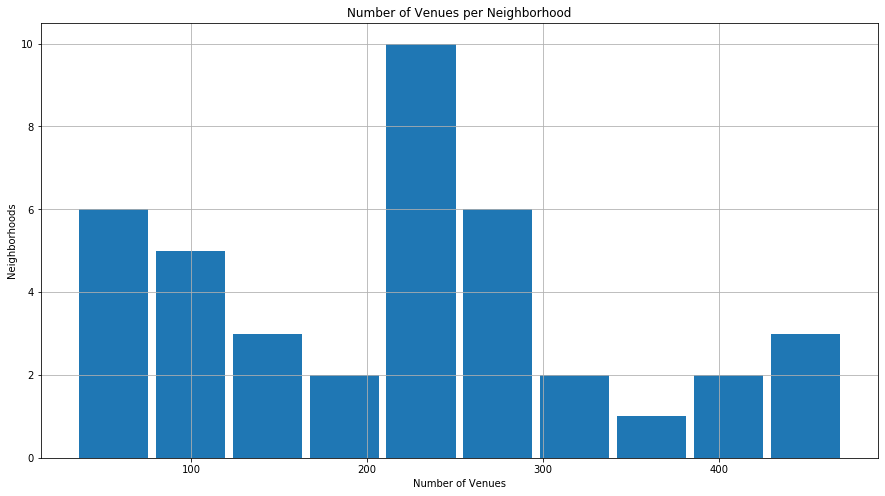

In [34]:
density_venues_in_neighborhood['Density'].hist(figsize=(15,8), rwidth=0.9)
plt.xlabel('Number of Venues')
plt.ylabel('Neighborhoods')
plt.title('Number of Venues per Neighborhood')
plt.show()

The 'Density' distribution shows that over 50% of the neighborhoods presents a density between 100 and 270 venues per area. Given that New York City has a high population density, this is quite expected. 

In [35]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smo

In [36]:
# the size of the new dataframe
manhattan_onehot.shape

(3307, 334)

In [37]:
#let's group rows by neighborhood and by taking the mean of the frequency of occurrentce of each category
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smo

In [38]:
manhattan_grouped.shape

(40, 334)

Let's create the new dataframe and display the top 10 venues for each neighborhood.

In [39]:
num_top_venues = 10

for hood in manhattan_grouped['Neighborhood']:
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Gym,Memorial Site,Clothing Store,Women's Store,Wine Shop,Grocery Store,Italian Restaurant
1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Yoga Studio,Bakery,Bookstore,Cosmetics Shop,French Restaurant,Gym,Japanese Restaurant
2,Central Harlem,Seafood Restaurant,Bar,African Restaurant,American Restaurant,French Restaurant,Fried Chicken Joint,Cosmetics Shop,Chinese Restaurant,Boutique,Gym
3,Chelsea,Coffee Shop,Bakery,Italian Restaurant,Ice Cream Shop,Nightclub,American Restaurant,Theater,Hotel,Art Gallery,Market
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bakery,Spa,Hotpot Restaurant,Boutique,Dumpling Restaurant


#### Let's create a function to get the nearby venues in each postal code in Old Toronto

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

oldtoronto_venues = getNearbyVenues(names=toronto_df_new['Neighborhood'], latitudes=toronto_df_new['Latitude'], longitudes=toronto_df_new['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

#### Let's check the size of the resulting dataframe

In [41]:
print(oldtoronto_venues.shape)
oldtoronto_venues.head()

(1708, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In order to get a better sense of the best way of clustering the neighborhoods, it is necessary to analyze the venues data returned by Foursquare.

In [42]:
venues_in_neighborhood1 = oldtoronto_venues.groupby('Neighborhood').count()
venues_in_neighborhood1 = pd.DataFrame(list(zip(venues_in_neighborhood1.index,venues_in_neighborhood1['Venue'])),
                                     columns=['Neighborhood','# of Venues']).set_index('Neighborhood').join(toronto_df_new[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
venues_in_neighborhood1['Distance'] = np.int64(venues_in_neighborhood1['Distance'])
venues_in_neighborhood1.head(10)

,Neighborhood,# of Venues,Distance
0,"Adelaide, King, Richmond",100,150
1,Berczy Park,56,111
2,"Brockton, Exhibition Place, Parkdale Village",22,703
3,Business Reply Mail Processing Centre 969 Eastern,16,423
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",14,834
5,"Cabbagetown, St. James Town",44,633
6,Central Bay Street,85,256
7,"Chinatown, Grange Park, Kensington Market",84,527
8,Christie,19,701
9,Church and Wellesley,83,322


In [43]:
venues_in_neighborhood1[['# of Venues']].describe()

,# of Venues
count,39.000000
mean,43.794872
std,35.643099
min,3.000000
25%,15.000000
50%,36.000000
75%,83.500000
max,100.000000


The venues frequency distribution is presented next.

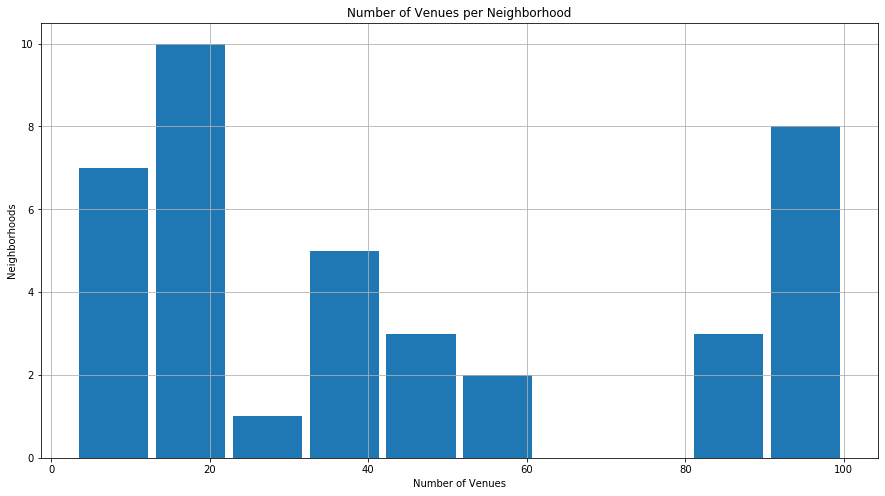

In [44]:
venues_in_neighborhood1['# of Venues'].hist(figsize=(15,8), rwidth=0.9)
plt.xlabel('Number of Venues')
plt.ylabel('Neighborhoods')
plt.title('Number of Venues per Neighborhood')
plt.show()

Given that each neighborhood has a different radius passed to the venues request, it's better to present the venues per Neighborhood in terms of density.

In [45]:
density_venues_in_neighborhood1 = oldtoronto_venues.groupby('Neighborhood').count()
density_venues_in_neighborhood1 = pd.DataFrame(list(zip(density_venues_in_neighborhood1.index, density_venues_in_neighborhood1['Venue'])),
                                             columns=['Neighborhood','Density']).set_index('Neighborhood').join(toronto_df_new[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
density_venues_in_neighborhood1['Density'] = np.int64(density_venues_in_neighborhood1['Density']/(density_venues_in_neighborhood1['Distance']/1000))  #distance in km

density_venues_in_neighborhood1.head(10)

,Neighborhood,Density,Distance
0,"Adelaide, King, Richmond",666,150.0
1,Berczy Park,504,111.0
2,"Brockton, Exhibition Place, Parkdale Village",31,703.0
3,Business Reply Mail Processing Centre 969 Eastern,37,423.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",16,834.0
5,"Cabbagetown, St. James Town",69,633.0
6,Central Bay Street,332,256.0
7,"Chinatown, Grange Park, Kensington Market",159,527.0
8,Christie,27,701.0
9,Church and Wellesley,257,322.0


In [46]:
density_venues_in_neighborhood1[['Density']].describe()

,Density
count,39.000000
mean,218.948718
std,359.463632
min,3.000000
25%,20.000000
50%,45.000000
75%,270.000000
max,1333.000000


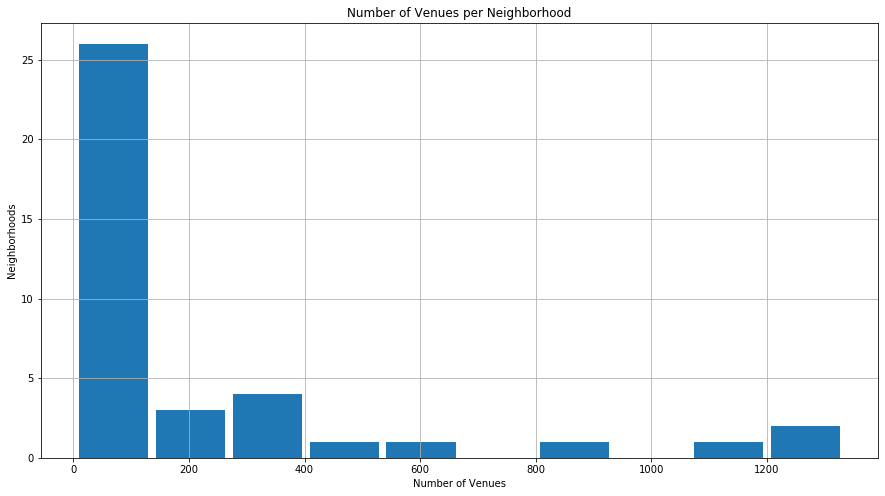

In [47]:
density_venues_in_neighborhood1['Density'].hist(figsize=(15,8), rwidth=0.9)
plt.xlabel('Number of Venues')
plt.ylabel('Neighborhoods')
plt.title('Number of Venues per Neighborhood')
plt.show()

The 'Density' distribution shows that over 50% of the neighborhoods presents a density between 0 and 50 venues per area. Given that Toronto has a low population density, this is quite expected and the rest of bars has low values, relatively. 

In [48]:
# one hot encoding
oldtoronto_onehot = pd.get_dummies(oldtoronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
oldtoronto_onehot['Neighborhood'] = oldtoronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns1 = [oldtoronto_onehot.columns[-1]] + list(oldtoronto_onehot.columns[:-1])
oldtoronto_onehot = oldtoronto_onehot[fixed_columns1]

oldtoronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

In [49]:
# the size of the new dataframe
oldtoronto_onehot.shape

(1708, 229)

In [50]:
#let's group rows by neighborhood and by taking the mean of the frequency of occurrentce of each category
oldtoronto_grouped = oldtoronto_onehot.groupby('Neighborhood').mean().reset_index()
oldtoronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.000000,0.0,0.03,0.0,0.0000,0.000000,0.0,0.000000,0.030000,0.0,0.030000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.01,0.000000,0.01,0.010000,0.0000,0.0,0.01,0.03,0.010000,0.0,0.000000,0.040000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.01,0.000000,0.070000,0.0,0.0,0.0,0.0,0.01,0.000000,0.0000,0.020000,0.000000,0.03,0.0,0.000000,0.0,0.0,0.0,0.01,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010000,0.0,0.0000,0.0000,0.0,0.02,0.0,0.0,0.01,0.0,0.01,0.000000,0.010000,0.000000,0.0

In [51]:
oldtoronto_grouped.shape

(39, 229)

Let's create the new dataframe and display the top 10 venues for each neighborhood.

In [52]:
num_top_venues = 10

for hood in oldtoronto_grouped['Neighborhood']:
    temp = oldtoronto_grouped[oldtoronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted1 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted1['Neighborhood'] = oldtoronto_grouped['Neighborhood']

for ind in np.arange(oldtoronto_grouped.shape[0]):
    neighborhoods_venues_sorted1.iloc[ind, 1:] = return_most_common_venues(oldtoronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,Burger Joint,Asian Restaurant,Bakery,Restaurant,Bar,Cosmetics Shop
1,Berczy Park,Coffee Shop,Farmers Market,Seafood Restaurant,Café,Cocktail Bar,Bakery,Steakhouse,Cheese Shop,Beer Bar,Basketball Stadium
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Gym,Grocery Store,Pet Store,Performing Arts Venue,Office,Italian Restaurant,Intersection
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Brewery,Pizza Place,Restaurant,Fast Food Restaurant,Auto Workshop,Farmers Market,Burrito Place,Spa,Recording Studio
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Sculpture Garden,Airport,Airport Food Court,Harbor / Marina,Boutique,Bar,Boat or Ferry


## 4. Cluster Neighborhoods

Next the neighborhoods are clustered based on venues density. In order to run *k*-means clustering, the elbow method is used to have a better sense of the optimal number of clusters.


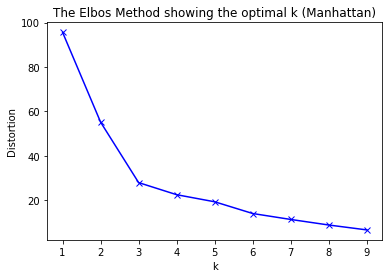

In [53]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters=k, n_init=12)
    k_means.fit(density_venues_in_neighborhood['Density'].values.reshape(-1,1))
    distortions.append(sum(np.min(cdist(density_venues_in_neighborhood['Density'].values.reshape(-1,1),
                          k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_neighborhood['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbos Method showing the optimal k (Manhattan)')
plt.show()

Using the elbow method, the optimal value of the number of cluster was defined as 3, which match with the value based on the histogram analysis.

In [54]:
# set number of clusters
kclusters = 3

# run k-means clustering
k_means = KMeans(init="k-means++", n_clusters=kclusters, n_init=12)
k_means.fit(density_venues_in_neighborhood['Density'].values.reshape(-1,1))
# check cluster labels generated for each row in the dataframe
labels = k_means.labels_ 
print(labels)

[0 0 2 0 1 0 1 2 0 0 0 0 1 2 1 2 0 2 1 2 2 2 2 0 0 2 0 0 2 1 2 0 0 0 0 0 2
 2 0 0]


In [55]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', k_means.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,663.0,2,Sandwich Place,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place,Department Store
1,Manhattan,Chinatown,40.715618,-73.994279,242.0,1,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bakery,Spa,Hotpot Restaurant,Boutique,Dumpling Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,1098.0,2,Café,Bakery,Grocery Store,Deli / Bodega,Mobile Phone Shop,Tapas Restaurant,Chinese Restaurant,Latin American Restaurant,Mexican Restaurant,Coffee Shop
3,Manhattan,Inwood,40.867684,-73.921210,663.0,2,Mexican Restaurant,Café,Pizza Place,Restaurant,Lounge,Deli / Bodega,American Restaurant,Park,Wine Bar,Bakery
4,Manhattan,Hamilton Heights,40.823604,-73.949688,492.0,2,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sandwich Place,Park,Sushi Restaurant,Bakery,Cocktail Bar


In [56]:
# add clustering labels
density_venues_in_neighborhood['Cluster'] = k_means.labels_
density_venues_in_neighborhood.head(10)

,Neighborhood,Density,Distance,Cluster
0,Battery Park City,259,374.0,0
1,Carnegie Hill,214,456.0,0
2,Central Harlem,87,504.0,2
3,Chelsea,182,549.0,0
4,Chinatown,413,242.0,1
5,Civic Center,243,410.0,0
6,Clinton,462,216.0,1
7,East Harlem,62,655.0,2
8,East Village,273,365.0,0
9,Financial District,267,374.0,0


Let's visualize the resulting clusters.

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As for Toronto, the neighborhoods are clustered based on venues density. In order to run *k*-means clustering, the elbow method is used to have a better sense of the optimal number of clusters.

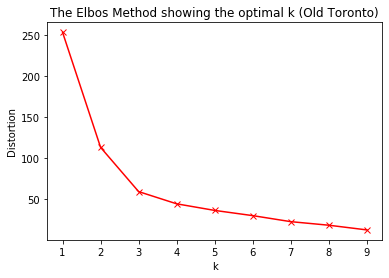

In [58]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means1 = KMeans(init = "k-means++", n_clusters=k, n_init=12)
    k_means1.fit(density_venues_in_neighborhood1['Density'].values.reshape(-1,1))
    distortions.append(sum(np.min(cdist(density_venues_in_neighborhood1['Density'].values.reshape(-1,1),
                          k_means1.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_neighborhood1['Density'].shape[0])

plt.plot(K, distortions, 'rx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbos Method showing the optimal k (Old Toronto)')
plt.show()

Using the elbow method, the optimal value of the number of cluster was defined as 3, which match with the value based on the histogram analysis.

In [59]:
# set number of clusters
kclusters = 3

# run k-means clustering
k_means1 = KMeans(init="k-means++", n_clusters=kclusters, n_init=12)
k_means1.fit(density_venues_in_neighborhood1['Density'].values.reshape(-1,1))
# check cluster labels generated for each row in the dataframe
labels = k_means1.labels_ 
print(labels)

[2 2 0 0 0 0 2 0 0 2 1 0 0 0 1 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 2 1 0 0 0
 0 0]


In [60]:
# add clustering labels
neighborhoods_venues_sorted1.insert(0, 'Cluster', k_means1.labels_)

oldtoronto_merged = toronto_df_new

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
oldtoronto_merged = oldtoronto_merged.join(neighborhoods_venues_sorted1.set_index('Neighborhood'), on='Neighborhood')

oldtoronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,994.0,0,Health Food Store,Trail,Pub,Women's Store,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,896.0,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant,Pub
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,423.0,0,Park,Gym,Pub,Sandwich Place,Burger Joint,Burrito Place,Italian Restaurant,Fast Food Restaurant,Fish & Chips Shop,Steakhouse
43,M4M,East Toronto,Studio District,43.659526,-79.340923,799.0,0,Café,Coffee Shop,Yoga Studio,Gastropub,Bakery,Brewery,Italian Restaurant,American Restaurant,Comfort Food Restaurant,Sandwich Place
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,851.0,0,Park,Swim School,Bus Line,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [61]:
# add clustering labels
density_venues_in_neighborhood1['Cluster'] = k_means1.labels_
density_venues_in_neighborhood1.head(10)

,Neighborhood,Density,Distance,Cluster
0,"Adelaide, King, Richmond",666,150.0,2
1,Berczy Park,504,111.0,2
2,"Brockton, Exhibition Place, Parkdale Village",31,703.0,0
3,Business Reply Mail Processing Centre 969 Eastern,37,423.0,0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",16,834.0,0
5,"Cabbagetown, St. James Town",69,633.0,0
6,Central Bay Street,332,256.0,2
7,"Chinatown, Grange Park, Kensington Market",159,527.0,0
8,Christie,27,701.0,0
9,Church and Wellesley,257,322.0,2


In [62]:
# create map
map_clusters1 = folium.Map(location=[latitude1, longitude1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(oldtoronto_merged['Latitude'], oldtoronto_merged['Longitude'], oldtoronto_merged['Neighborhood'], oldtoronto_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

## 5. Examine clusters

Check the centroid values of venues density and neighborhoods per cluster for Manhattan.

In [63]:
centroids = np.int64(round(density_venues_in_neighborhood.groupby('Cluster').mean()['Density']))
frequency = density_venues_in_neighborhood.groupby('Cluster').count()['Neighborhood']
cluster_info = pd.DataFrame([np.arange(0,3), centroids, frequency], index=['Cluster','Centroid','Neighborhood']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Neighborhood
0,2,84,14
1,0,246,20
2,1,429,6


#### Cluster 1

In [64]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,0,Italian Restaurant,Exhibit,Art Gallery,Bakery,Gym / Fitness Center,Juice Bar,Hotel,French Restaurant,Pizza Place,Coffee Shop
9,Yorkville,0,Coffee Shop,Bar,Gym,Italian Restaurant,Pizza Place,Deli / Bodega,Japanese Restaurant,Mexican Restaurant,Sushi Restaurant,Diner
10,Lenox Hill,0,Coffee Shop,Pizza Place,Italian Restaurant,Cocktail Bar,Sushi Restaurant,Gym,Café,Burger Joint,Gym / Fitness Center,Turkish Restaurant
15,Midtown,0,Hotel,Theater,Coffee Shop,Sporting Goods Shop,Clothing Store,Steakhouse,Bakery,Café,Bookstore,French Restaurant
16,Murray Hill,0,Coffee Shop,Sandwich Place,Hotel,American Restaurant,Japanese Restaurant,Gym / Fitness Center,Italian Restaurant,Sushi Restaurant,Steakhouse,Bar
17,Chelsea,0,Coffee Shop,Bakery,Italian Restaurant,Ice Cream Shop,Nightclub,American Restaurant,Theater,Hotel,Art Gallery,Market
19,East Village,0,Bar,Ice Cream Shop,Chinese Restaurant,Mexican Restaurant,Wine Bar,Pizza Place,Cocktail Bar,Coffee Shop,Speakeasy,Japanese Restaurant
21,Tribeca,0,American Restaurant,Italian Restaurant,Park,Spa,Café,Wine Bar,Coffee Shop,Men's Store,Greek Restaurant,Poke Place
24,West Village,0,Italian Restaurant,New American Restaurant,Cosmetics Shop,Park,Cocktail Bar,Wine Bar,American Restaurant,Coffee Shop,Theater,Bakery
27,Gramercy,0,Bar,Bagel Shop,Mexican Restaurant,Thai Restaurant,Pizza Place,Italian Restaurant,Grocery Store,Comedy Club,Thrift / Vintage Store,Cocktail Bar


#### Cluster 2

In [65]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,1,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bakery,Spa,Hotpot Restaurant,Boutique,Dumpling Restaurant
14,Clinton,1,Theater,Italian Restaurant,Gym / Fitness Center,Spa,American Restaurant,Coffee Shop,Wine Shop,Hotel,Gym,Sandwich Place
18,Greenwich Village,1,Italian Restaurant,Clothing Store,Sushi Restaurant,Café,French Restaurant,Ice Cream Shop,Indian Restaurant,Seafood Restaurant,Dessert Shop,Caribbean Restaurant
22,Little Italy,1,Café,Bakery,Bubble Tea Shop,Pizza Place,Mediterranean Restaurant,Sandwich Place,Italian Restaurant,Cocktail Bar,Salon / Barbershop,Thai Restaurant
23,Soho,1,Clothing Store,Boutique,Italian Restaurant,Women's Store,Furniture / Home Store,Shoe Store,Art Gallery,Sporting Goods Shop,Bakery,Men's Store
39,Hudson Yards,1,American Restaurant,Gym / Fitness Center,Italian Restaurant,Hotel,Coffee Shop,Café,Bar,Thai Restaurant,Gym,Restaurant


#### Cluster 3

In [66]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,2,Sandwich Place,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place,Department Store
2,Washington Heights,2,Café,Bakery,Grocery Store,Deli / Bodega,Mobile Phone Shop,Tapas Restaurant,Chinese Restaurant,Latin American Restaurant,Mexican Restaurant,Coffee Shop
3,Inwood,2,Mexican Restaurant,Café,Pizza Place,Restaurant,Lounge,Deli / Bodega,American Restaurant,Park,Wine Bar,Bakery
4,Hamilton Heights,2,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sandwich Place,Park,Sushi Restaurant,Bakery,Cocktail Bar
5,Manhattanville,2,Coffee Shop,Mexican Restaurant,Fried Chicken Joint,Park,Seafood Restaurant,Deli / Bodega,Italian Restaurant,Bus Station,Café,Ramen Restaurant
6,Central Harlem,2,Seafood Restaurant,Bar,African Restaurant,American Restaurant,French Restaurant,Fried Chicken Joint,Cosmetics Shop,Chinese Restaurant,Boutique,Gym
7,East Harlem,2,Mexican Restaurant,Thai Restaurant,Bakery,Latin American Restaurant,Deli / Bodega,Pharmacy,Spanish Restaurant,Beer Bar,Taco Place,Gas Station
11,Roosevelt Island,2,Park,Sandwich Place,School,Gym,Baseball Field,Greek Restaurant,Liquor Store,Scenic Lookout,Outdoors & Recreation,Coffee Shop
12,Upper West Side,2,Italian Restaurant,Wine Bar,Bar,Coffee Shop,Café,Mediterranean Restaurant,Bakery,Indian Restaurant,Breakfast Spot,Pub
13,Lincoln Square,2,Plaza,Theater,Italian Restaurant,Concert Hall,Café,Performing Arts Venue,French Restaurant,American Restaurant,Indie Movie Theater,Gym


Check the centroid values of venues density and neighborhoods per cluster for Old Toronto.

In [67]:
centroids = np.int64(round(density_venues_in_neighborhood1.groupby('Cluster').mean()['Density']))
frequency = density_venues_in_neighborhood1.groupby('Cluster').count()['Neighborhood']
cluster_info = pd.DataFrame([np.arange(0,3), centroids, frequency], index=['Cluster','Centroid','Neighborhood']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Neighborhood
0,0,43,28
1,2,390,7
2,1,1155,4


#### Cluster 1

In [68]:
oldtoronto_merged.loc[oldtoronto_merged['Cluster'] == 0, oldtoronto_merged.columns[[0,1,2] + list(range(5, oldtoronto_merged.shape[1]))]]

,Postal Code,Borough,Neighborhood,Distance,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,994.0,0,Health Food Store,Trail,Pub,Women's Store,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
41,M4K,East Toronto,"The Danforth West, Riverdale",896.0,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant,Pub
42,M4L,East Toronto,"The Beaches West, India Bazaar",423.0,0,Park,Gym,Pub,Sandwich Place,Burger Joint,Burrito Place,Italian Restaurant,Fast Food Restaurant,Fish & Chips Shop,Steakhouse
43,M4M,East Toronto,Studio District,799.0,0,Café,Coffee Shop,Yoga Studio,Gastropub,Bakery,Brewery,Italian Restaurant,American Restaurant,Comfort Food Restaurant,Sandwich Place
44,M4N,Central Toronto,Lawrence Park,851.0,0,Park,Swim School,Bus Line,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
45,M4P,Central Toronto,Davisville North,472.0,0,Gym,Hotel,Dance Studio,Department Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Park,Gas Station,Deli / Bodega
46,M4R,Central Toronto,North Toronto West,496.0,0,Clothing Store,Coffee Shop,Yoga Studio,Mexican Restaurant,Diner,Spa,Salon / Barbershop,Sporting Goods Shop,Dessert Shop,Fast Food Restaurant
47,M4S,Central Toronto,Davisville,472.0,0,Sandwich Place,Dessert Shop,Gym,Sushi Restaurant,Café,Pizza Place,Italian Restaurant,Coffee Shop,Optical Shop,Brewery
48,M4T,Central Toronto,"Moore Park, Summerhill East",601.0,0,Restaurant,Playground,Tennis Court,Trail,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Women's Store
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",701.0,0,Pub,Coffee Shop,American Restaurant,Liquor Store,Sports Bar,Restaurant,Supermarket,Sushi Restaurant,Fried Chicken Joint,Light Rail Station


#### Cluster 2

In [69]:
oldtoronto_merged.loc[oldtoronto_merged['Cluster'] == 1, oldtoronto_merged.columns[[0,1,2] + list(range(5, oldtoronto_merged.shape[1]))]]

,Postal Code,Borough,Neighborhood,Distance,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",75.0,1,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Seafood Restaurant,Deli / Bodega,Gastropub,Bar,Steakhouse
61,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",91.0,1,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Gym,Seafood Restaurant,Steakhouse,Gastropub,Deli / Bodega
69,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,111.0,1,Coffee Shop,Café,Restaurant,Japanese Restaurant,Seafood Restaurant,Beer Bar,Hotel,Italian Restaurant,Park,Cheese Shop
70,M5X,Downtown Toronto,"First Canadian Place, Underground city",75.0,1,Coffee Shop,Café,Restaurant,Steakhouse,Japanese Restaurant,Burger Joint,Seafood Restaurant,Bar,Deli / Bodega,Gym


#### Cluster 3

In [70]:
oldtoronto_merged.loc[oldtoronto_merged['Cluster'] == 2, oldtoronto_merged.columns[[0,1,2] + list(range(5, oldtoronto_merged.shape[1]))]]

,Postal Code,Borough,Neighborhood,Distance,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,M4Y,Downtown Toronto,Church and Wellesley,322.0,2,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gastropub
54,M5B,Downtown Toronto,"Ryerson, Garden District",342.0,2,Coffee Shop,Clothing Store,Cosmetics Shop,Japanese Restaurant,Café,Fast Food Restaurant,Diner,Ramen Restaurant,Bookstore,Bakery
55,M5C,Downtown Toronto,St. James Town,254.0,2,Café,Restaurant,Coffee Shop,Italian Restaurant,Breakfast Spot,Clothing Store,Cocktail Bar,Beer Bar,Cosmetics Shop,Bakery
56,M5E,Downtown Toronto,Berczy Park,111.0,2,Coffee Shop,Farmers Market,Seafood Restaurant,Café,Cocktail Bar,Bakery,Steakhouse,Cheese Shop,Beer Bar,Basketball Stadium
57,M5G,Downtown Toronto,Central Bay Street,256.0,2,Coffee Shop,Italian Restaurant,Café,Burger Joint,Sandwich Place,Ice Cream Shop,Juice Bar,Japanese Restaurant,Chinese Restaurant,Bubble Tea Shop
58,M5H,Downtown Toronto,"Adelaide, King, Richmond",150.0,2,Coffee Shop,Café,Steakhouse,Thai Restaurant,Burger Joint,Asian Restaurant,Bakery,Restaurant,Bar,Cosmetics Shop
59,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",353.0,2,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Fried Chicken Joint,Scenic Lookout,Restaurant,Sporting Goods Shop,Brewery
